In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [6]:
df = pd.read_csv('../../datasets/wind_dataset.csv')
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


<Axes: xlabel='DATE'>

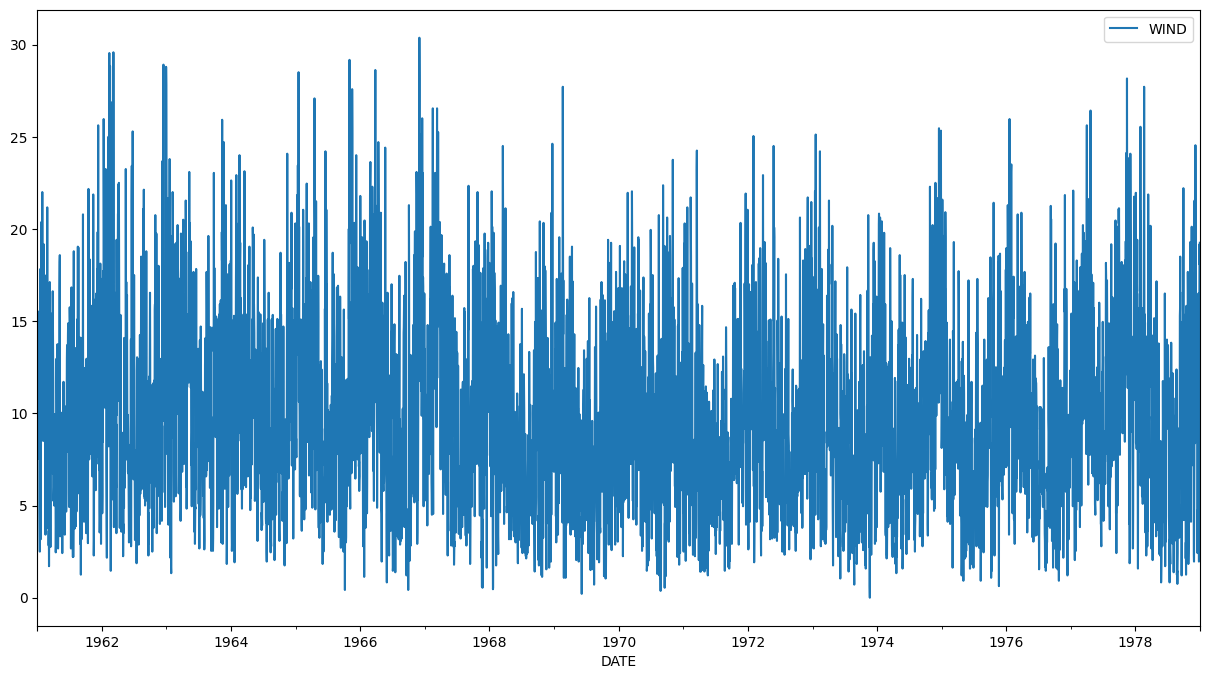

In [8]:
df['DATE']=pd.to_datetime(df['DATE'])
df.plot(x='DATE',y='WIND',figsize=(15,8))

<Axes: >

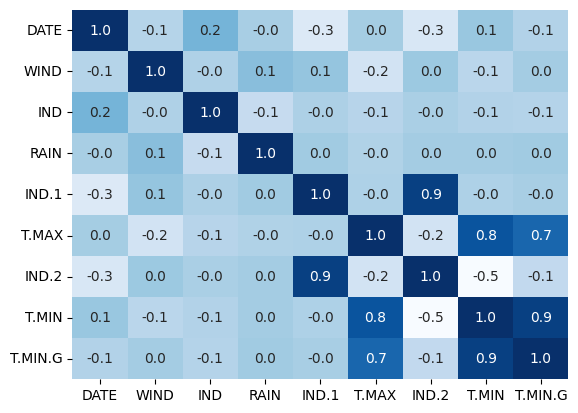

In [9]:
sns.heatmap(df.corr(),annot=True,cbar=False,cmap='Blues',fmt='.1f')

<Axes: ylabel='WIND'>

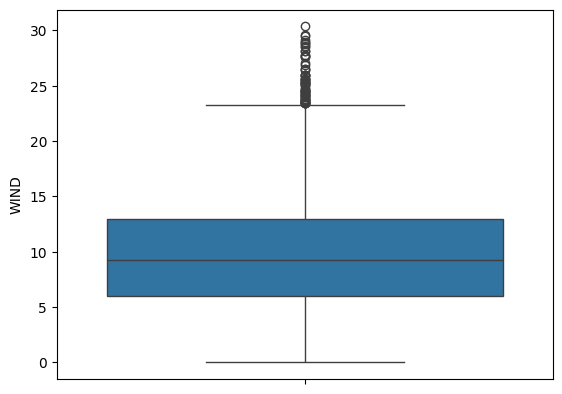

In [10]:
sns.boxplot(df['WIND'])

<Axes: ylabel='RAIN'>

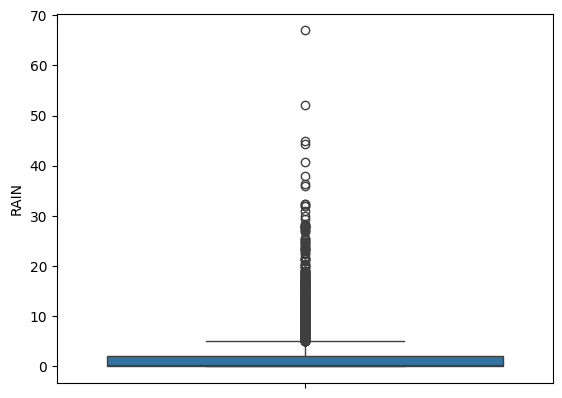

In [11]:
sns.boxplot(df['RAIN'])

<Axes: ylabel='T.MAX'>

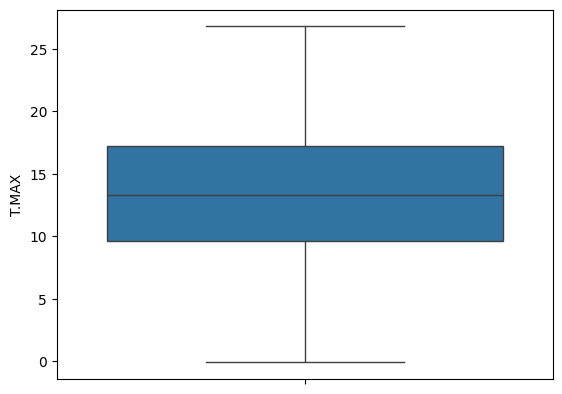

In [12]:
sns.boxplot(df['T.MAX'])

<Axes: ylabel='T.MIN'>

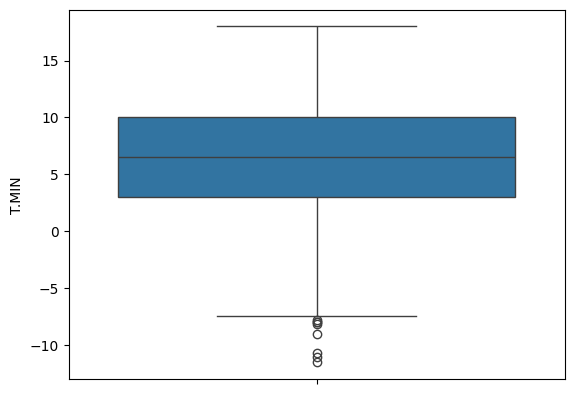

In [13]:
sns.boxplot(df['T.MIN'])

<Axes: ylabel='T.MIN.G'>

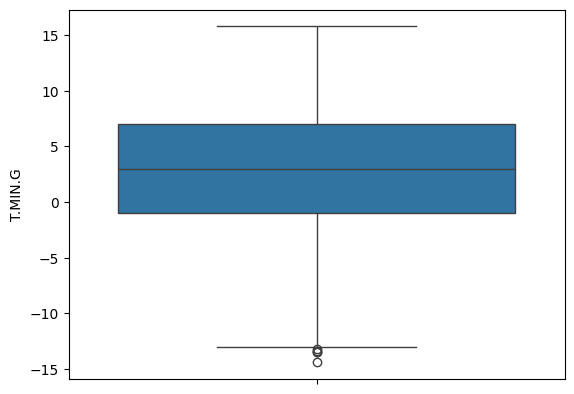

In [14]:
sns.boxplot(df['T.MIN.G'])

<Axes: xlabel='IND', ylabel='Count'>

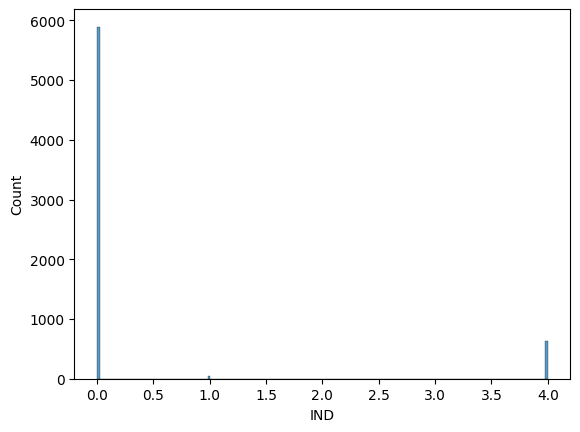

In [15]:
sns.histplot(df['IND'])

<Axes: xlabel='IND.1', ylabel='Count'>

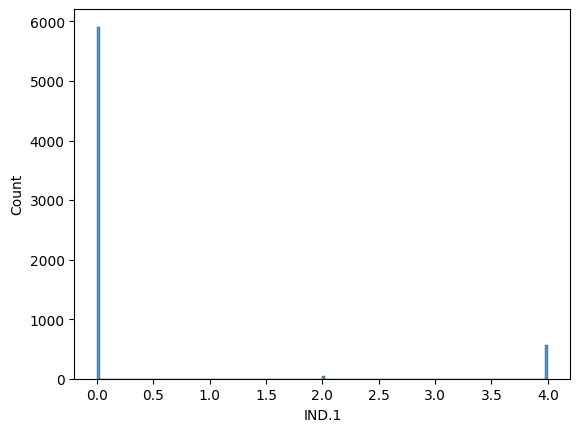

In [16]:
sns.histplot(df['IND.1'])

<Axes: xlabel='IND.2', ylabel='Count'>

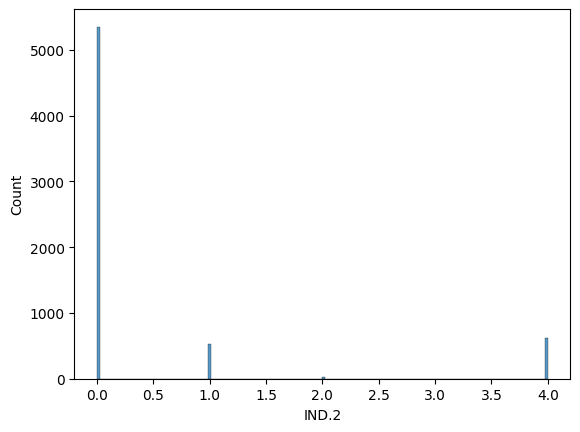

In [17]:
sns.histplot(df['IND.2'])

In [18]:
df = df.set_index('DATE')

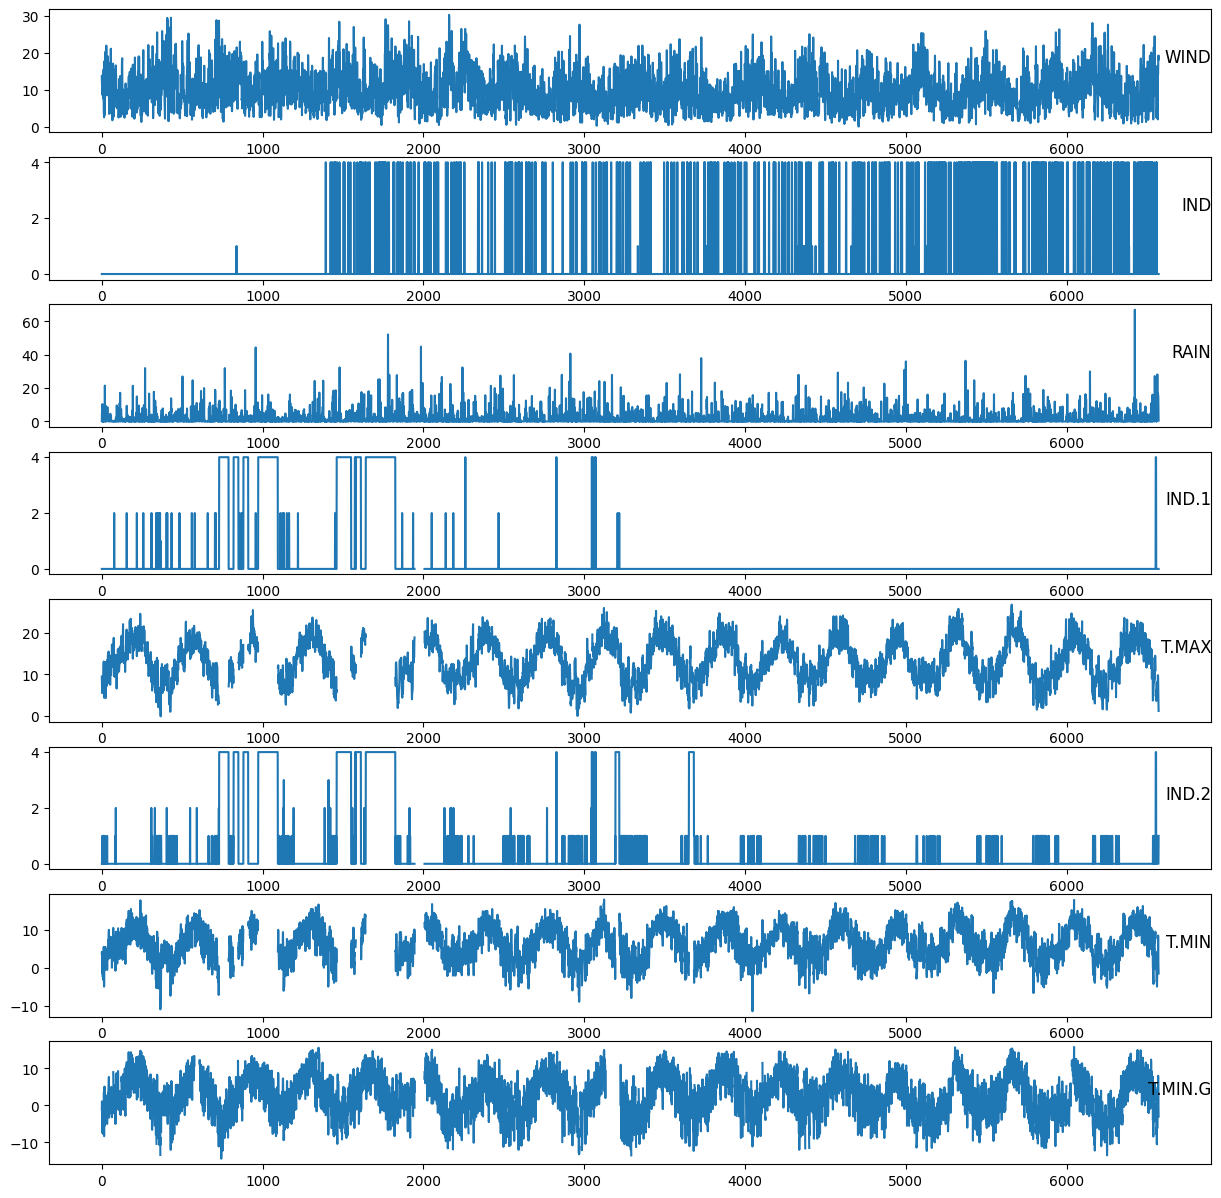

In [19]:
from matplotlib import pyplot

values = df.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1

pyplot.figure(figsize=(15,15))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## Features Engineering

In [20]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND      6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND.1    6574 non-null   float64
 4   T.MAX    6574 non-null   float64
 5   IND.2    6574 non-null   float64
 6   T.MIN    6574 non-null   float64
 7   T.MIN.G  6574 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 462.2 KB


In [21]:
6574*0.7

4601.799999999999

In [22]:
train_df,test_df = df[1:4601], df[4601:]

In [23]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [24]:
def split_series(series, n_past, n_future):
  
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [25]:
n_past = 10
n_future = 5 
n_features = 8

In [26]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

## Modeling

In [27]:
# E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer.

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_e1d1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 100),     │     43,600 │ input_layer[0][0] │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 100)    │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 5, 100)    │     80,400 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 8)      │        808 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,808 (487.53 KB)

 Trainable params: 124,808 (487.53 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers.

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 10, 100), │     43,600 │ input_layer_1[0]… │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 100),     │     80,400 │ lstm_2[0][0]      │
│                     │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 5, 100)    │          0 │ lstm_3[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 5, 100)    │     80,400 │ repeat_vector_1[… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 5, 100)    │     80,400 │ lstm_4[0][0],     │
│                     │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 8)      │        808 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 285,608 (1.09 MB)

 Trainable params: 285,608 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

## Training the models

In [29]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [30]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


## Inverse Scaling of the predicted values

In [31]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

## Checking Error

In [32]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,6):
    print("Day ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
  print()
  print()

WIND
Day  1 :
MAE-E1D1 :  3.04098634602039, MAE-E2D2 :  3.101042934298941
Day  2 :
MAE-E1D1 :  3.4892151532506626, MAE-E2D2 :  3.531334551504037
Day  3 :
MAE-E1D1 :  3.6050474359357523, MAE-E2D2 :  3.640670709663535
Day  4 :
MAE-E1D1 :  3.6465242188800775, MAE-E2D2 :  3.682052026225816
Day  5 :
MAE-E1D1 :  3.694963175348629, MAE-E2D2 :  3.7241461579370037


IND
Day  1 :
MAE-E1D1 :  0.8066475067046177, MAE-E2D2 :  0.8127409336577879
Day  2 :
MAE-E1D1 :  0.8044174815270899, MAE-E2D2 :  0.8095620439148729
Day  3 :
MAE-E1D1 :  0.7936203776725158, MAE-E2D2 :  0.7976772163886693
Day  4 :
MAE-E1D1 :  0.7847347909422052, MAE-E2D2 :  0.7887839675862428
Day  5 :
MAE-E1D1 :  0.7804812669388915, MAE-E2D2 :  0.7875074768261133


RAIN
Day  1 :
MAE-E1D1 :  2.3633284568497572, MAE-E2D2 :  2.279038170402971
Day  2 :
MAE-E1D1 :  2.417416136395025, MAE-E2D2 :  2.3366434149048567
Day  3 :
MAE-E1D1 :  2.366471980468785, MAE-E2D2 :  2.3265235456171665
Day  4 :
MAE-E1D1 :  2.3821095693105336, MAE-E2D2 :  2.3